# Running ResNet18 with `fastai` on NVIDIA Jetson

NVIDIA Jetson devices provide powerful AI inference capabilities at the edge, and with the right setup, you can efficiently run deep learning models like ResNet18 using the fastai library. This guide walks you through installing necessary dependencies, setting up PyTorch and fastai, and running inference using a ResNet18 model.

## Installation

This guide provides step-by-step instructions for setting up an [NVIDIA® Jetson Orin Nano™ Developer Kit](https://developer.nvidia.com/embedded/learn/jetson-orin-nano-devkit-user-guide/index.html) for deep learning with PyTorch, torchvision, and fastai. The setup will be performed via a terminal from a host machine connected via USB or serial connection.

### Software and Package Versions

- **JetPack** - 6.2 (also compatible with 6.1)  
- **CUDA** - 12.6  
- **Python** - 3.10  
- **cuSPARSELt** - 0.7.0  
- **torch** - 2.5.0a0+872d972e41 ([NVIDIA wheel](https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch)).  
- **torchvision** - 0.20.0 (built from source)  
- **spacy** - 3.7.2  
- **fastai** - 2.7.18  

### Step 1 - Installing JetPack and SDK Components

The Jetson device must be flashed with JetPack, which includes the Jetson Linux OS and necessary GPU computing libraries such as CUDA and cuDNN. Follow the official [NVIDIA JetPack installation guide](https://developer.nvidia.com/embedded/jetpack-sdk-62) for instructions. Ensure that firmware version is updated to 36+ for JetPack > 6.

To flash Jetson Orin Nano, install [NVIDIA SDK Manager](https://docs.nvidia.com/sdk-manager/index.html) on a Linux host machine and follow the setup steps. During flashing, select Jetson SDK Components to install CUDA toolkit in the [second step](https://docs.nvidia.com/sdk-manager/install-with-sdkm-jetson/index.html#step-02-review-components-and-accept-licenses). If CUDA is missing post-installation, follow the JetPack [package management guide](https://docs.nvidia.com/jetson/jetpack/install-setup/index.html#package-management-tool).

CUDA installation can be verified with:
```
$ nvcc --version
```
or
```
$ nvidia-smi
```
For additional verification, compile and run a CUDA sample:
```
$ git clone https://github.com/NVIDIA/cuda-samples
$ cd cuda-samples/Samples/1_Utilities/deviceQuery
$ make
$ ./deviceQuery
```

### Step 2 - Installing PyTorch and torchvision

Jetson devices use integrated GPUs (iGPUs) while default CUDA backend of PyTorch is optimized for discrete GPUs (dGPUs). To enable PyTorch with GPU acceleration on Jetson, follow the custom installation available in [NVIDIA instructions](https://docs.nvidia.com/deeplearning/frameworks/install-pytorch-jetson-platform/index.html) and [NVIDIA forums](https://forums.developer.nvidia.com/t/pytorch-for-jetson/72048). The supporting package torchvision also has to be built from source on the Jetson device.

#### Installing cuSPARSELt

For PyTorch versions 24.06+ (see [Compatibility Matrix](https://docs.nvidia.com/deeplearning/frameworks/install-pytorch-jetson-platform-release-notes/pytorch-jetson-rel.html#pytorch-jetson-rel)), cuSPARSELt is required. Install it with these [instructions](https://developer.nvidia.com/cusparselt-downloads) by selecting Linux OS, aarch64-jetson architecture, and Ubuntu distribution:
```
$ wget https://developer.download.nvidia.com/compute/cusparselt/0.7.0/local_installers/cusparselt-local-tegra-repo-ubuntu2204-0.7.0_1.0-1_arm64.deb
$ sudo dpkg -i cusparselt-local-tegra-repo-ubuntu2204-0.7.0_1.0-1_arm64.deb
$ sudo cp /var/cusparselt-local-tegra-repo-ubuntu2204-0.7.0/cusparselt-*-keyring.gpg /usr/share/keyrings/
$ sudo apt-get update
$ sudo apt-get -y install libcusparselt0 libcusparselt-dev
```

#### Installing PyTorch

Create a virtual environment (recommended):

```
$ sudo apt-get install virtualenv
$ cd <target-directory>
$ python3 -m virtualenv -p python3 <venv-name>
$ source <venv-name>/bin/activate
```

Install PyTorch with a custom wheel built by NVIDIA:  

1. Check compatibility from [NVIDIA Jetson PyTorch matrix](https://docs.nvidia.com/deeplearning/frameworks/install-pytorch-jetson-platform-release-notes/pytorch-jetson-rel.html).  
2. Select suitable wheel from [list of released wheels](https://developer.download.nvidia.com/compute/redist/jp/) by selecting `v$JP_VERSION` (JetPack version) > `pytorch` > `$PYT_VERSION ... .whl` (PyTorch version).  
3. Install with pip - 
```
pip3 install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v$JP_VERSION/pytorch/$PYT_VERSION ... .whl
```

In this tutorial, PyTorch version 2.5 for JetPack 6.1 (still compatible with 6.2) will be installed with:
```
pip3 install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl
```

Verify with Python Terminal:
```
$ python3
>>> import torch
>>> print(torch.__version__)
>>> print('CUDA available: ' + str(torch.cuda.is_available()))
>>> print('cuDNN version: ' + str(torch.backends.cudnn.version()))
>>> a = torch.cuda.FloatTensor(2).zero_()
>>> print('Tensor a = ' + str(a))
>>> b = torch.randn(2).cuda()
>>> print('Tensor b = ' + str(b))
>>> c = a + b
>>> print('Tensor c = ' + str(c))
```

#### Installing torchvision

torchvision must be built from source:
```
$ sudo apt-get install libjpeg-dev zlib1g-dev libpython3-dev libopenblas-dev libavcodec-dev libavformat-dev libswscale-dev
$ git clone --branch release/$VERSION https://github.com/pytorch/vision torchvision
$ cd torchvision
$ export BUILD_VERSION=0.$VERSION.0
$ python3 setup.py install --user # remove --user if installing in virtualenv
```

In this tutorial, torchvision version 0.20.0 is installed by replacing `$VERSION` with 20.

Verify with Python terminal:
```
$ python3
>>> import torchvision
>>> print(torchvision.__version__)
```

### Step 3 - Installing fastai

Ensure PyTorch and torchvision were installed first to avoid version conflicts, note that fastai version 2.7.18 requires torch < 2.6. Install fastai and dependencies:

```
pip install spacy==3.7.2
pip install fastai
```

**Troubleshooting**: spacy version 3.7.2 is installed first because building wheel for spacy version 3.8.3 can fail on this architecture.

### Step 4 - (Optional) Setting up Jupyter Notebook for Remote Access

To enable remote access to Jupyter Notebook from another device, first install Jupyter Notebook and Jupyterlab:

```
pip install jupyterlab
pip install notebook
```

To use a remote server running from a Jetson device:

- Check IP address of Jetson device with Linux command `$ ip a`  
- Start server from Jetson terminal: `$ jupyter notebook --no-browser --port=8888 --ip=0.0.0.0`  
- Access with `http://<jetson-ip-address>:8888`

## Imagenette data

In [ ]:
#| eval: false
from fastai.vision.all import *

In [ ]:
#| eval: false
path = untar_data(URLs.IMAGENETTE_320, data=Path.cwd()/'data')
path.ls()

(#3) [Path('/home/jetson/jetson-examples/fastai/data/imagenette2-320/noisy_imagenette.csv'),Path('/home/jetson/jetson-examples/fastai/data/imagenette2-320/val'),Path('/home/jetson/jetson-examples/fastai/data/imagenette2-320/train')]

In [ ]:
#| eval: false
train_files = get_image_files(path/'train')
val_files = get_image_files(path/'val')

print(f"Training set size: {len(train_files)}")
print(f"Validation set size: {len(val_files)}")

Training set size: 9469
Validation set size: 3925


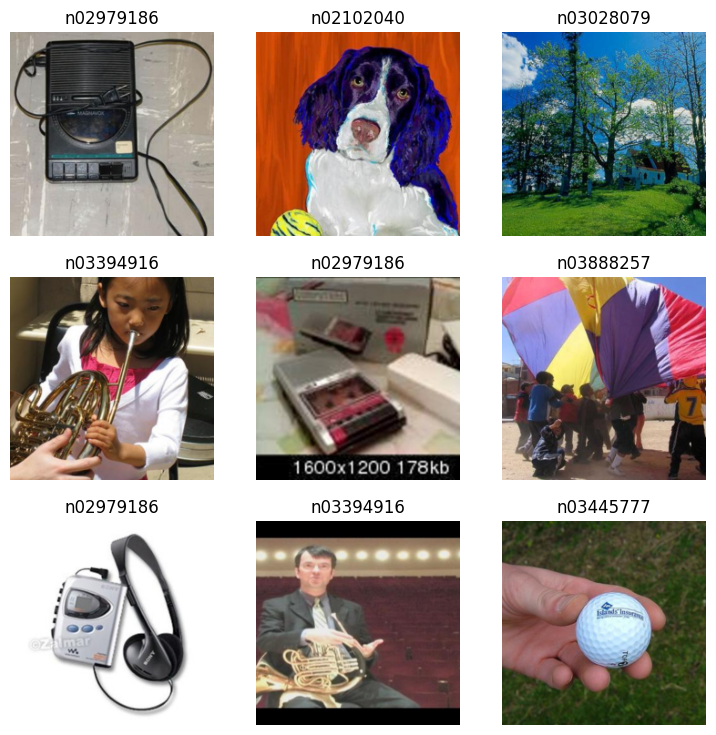

In [ ]:
#| eval: false
dls = ImageDataLoaders.from_folder(path, valid='val', item_tfms=Resize(224), batch_tfms=Normalize.from_stats(*imagenet_stats),)
dls.show_batch()

## Train Resnet18

In [ ]:
#| eval: false
learn = vision_learner(dls, resnet18, metrics=accuracy, pretrained=True)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jetson/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:04<00:00, 10.4MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.256327,0.057777,0.981147,01:05


epoch,train_loss,valid_loss,accuracy,time
0,0.095958,0.054148,0.982166,01:13


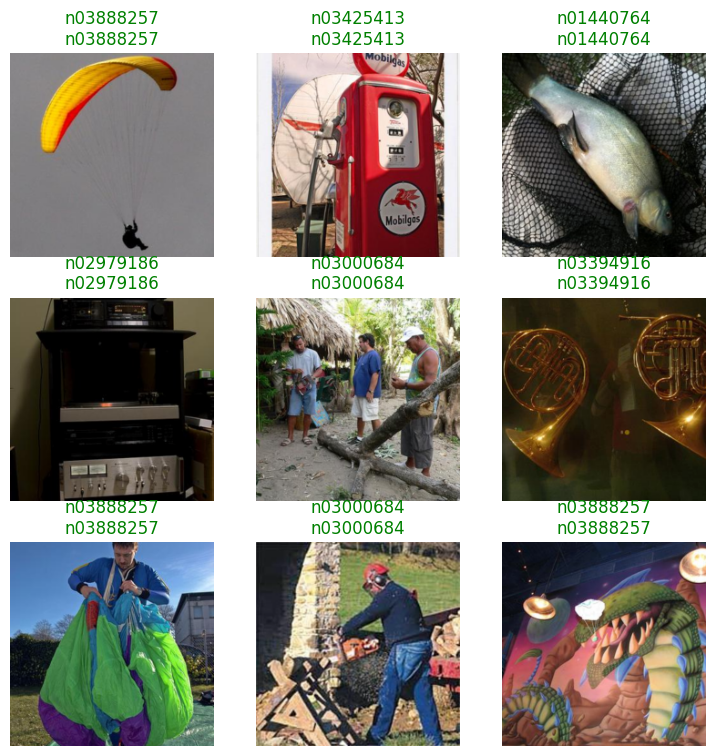

In [ ]:
#| eval: false
learn.show_results()

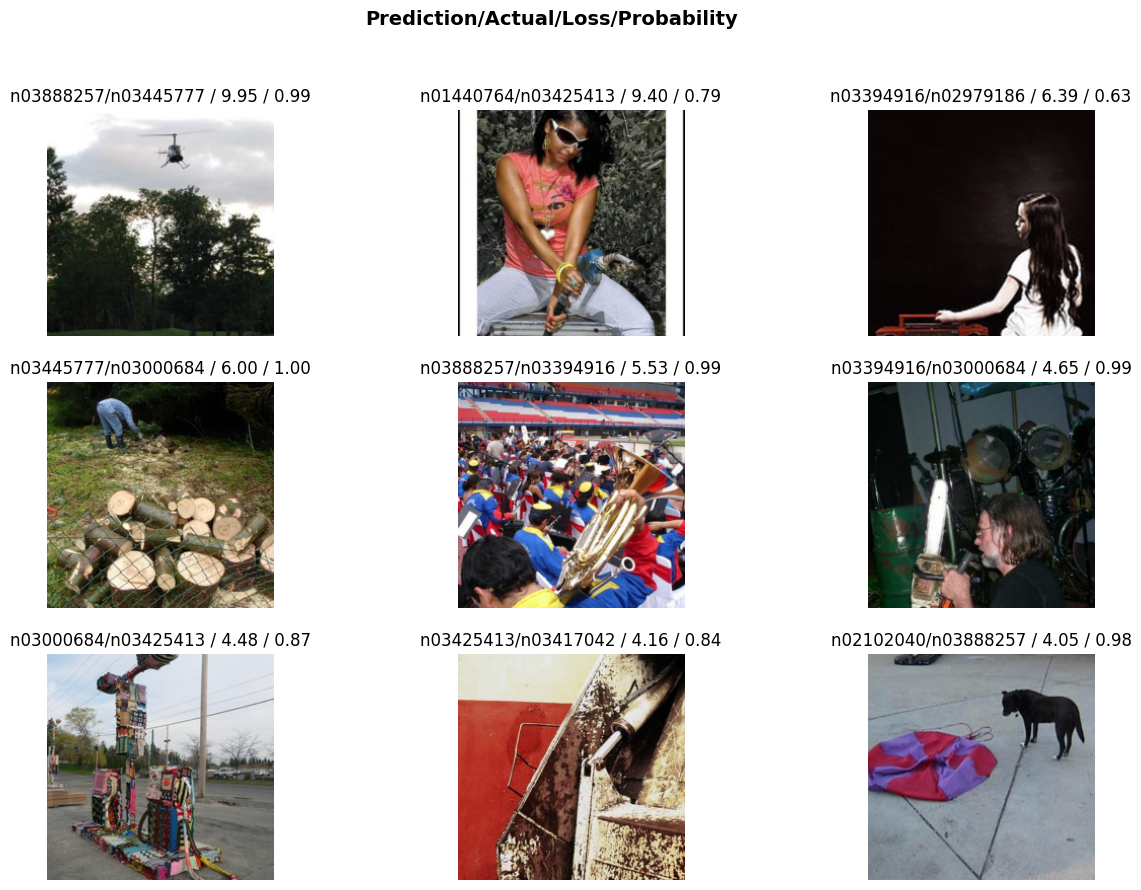

In [ ]:
#| eval: false
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

## Inference

/home/jetson/jetson-examples/fastai/data/imagenette2-320/train/n03888257/n03888257_457.JPEG


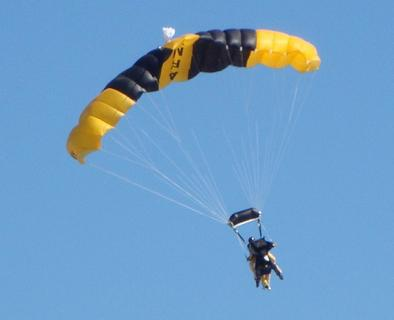

In [ ]:
#| eval: false
print(train_files[0])
Image.open(train_files[0])

In [ ]:
#| eval: false
learn.predict(train_files[0])

('n03888257',
 tensor(9),
 tensor([3.8436e-09, 1.0198e-09, 1.5029e-09, 5.9055e-10, 3.6786e-09, 3.4041e-11,
         1.1457e-09, 2.3508e-10, 2.6311e-10, 1.0000e+00]))